# <center> cs231. Assignment 2.

Goal is to build convolutional neural network with linear layers to work on CIFAR-10 dataset and reach at least $70\%$ accuracy on test set. This is a part where I use PyTorch for this.

## Importing libs

Load all the necessary libs, including my scripts for training and visualizations.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import sys
import os
import glob
import pickle

# ================================================

if not '..' in sys.path:
    sys.path = ['..'] + sys.path

import torch
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.sampler import RandomSampler, SequentialSampler

from _cs231n.torch_utils import *
from _cs231n.metrics import accuracy, confusion_matrix

# ================================================

PATH_TO_DATA = '../data/cifar-10-batches-py'

## Loading & visualizing dataset

Dataset has been previously downloaded from [here](https://www.cs.toronto.edu/~kriz/cifar.html). There is a script `get_data.sh` in `assignment1` folder for this. Dataset is already split into train and test.

We will also normalize dataset on each of 3 channels separately to zero mean and unit variance.

In [2]:
X_train0 = []
y_train0 = []

for fname in glob.glob(os.path.join(PATH_TO_DATA, 'data_batch_*')):
    with open(fname, 'rb') as fh:
        batch = pickle.load(fh, encoding='bytes')
        
    X_train0.append(batch[b'data'])
    y_train0 += batch[b'labels']
    
X_train0 = np.vstack(X_train0).astype(np.float64)/255
X_train0 = X_train0.reshape(-1, 3, 32, 32).transpose((0, 2, 3, 1))
y_train0 = np.array(y_train0)
print('Training data shape: {0}x{1}'.format(*X_train0.shape))

# ================================================

with open(os.path.join(PATH_TO_DATA, 'test_batch'), 'rb') as fh:
    batch = pickle.load(fh, encoding='bytes')
    
    X_test0 = batch[b'data'].astype(np.float64)/255
    X_test0 = X_test0.reshape(-1, 3, 32, 32).transpose((0, 2, 3, 1))
    y_test0 = batch[b'labels']
    
print('Test data shape: {0}x{1}'.format(*X_test0.shape))

# ================================================
# Load images categories

with open(os.path.join(PATH_TO_DATA, 'batches.meta'), 'rb') as fh:
    categories_meta = pickle.load(fh, encoding='bytes')
    categories = [x.decode('UTF-8') for x in categories_meta[b'label_names']]
    
# ================================================
# Normalize dataset separately on each channel
    
X_mean = X_train0.mean(axis=(0, 1, 2))
X_std = X_train0.reshape(X_train0.shape[0], 3, -1).std(axis=(0, 2))

X_train_norm = (X_train0 - X_mean[None, None, None, :])/X_std[None, None, None, :]
X_test_norm = (X_test0 - X_mean[None, None, None, :])/X_std[None, None, None, :]

Training data shape: 50000x32
Test data shape: 10000x32


Let's visualize dataset to see what we're dealing with. There are 10 categories of images, we will display several pics from each category.

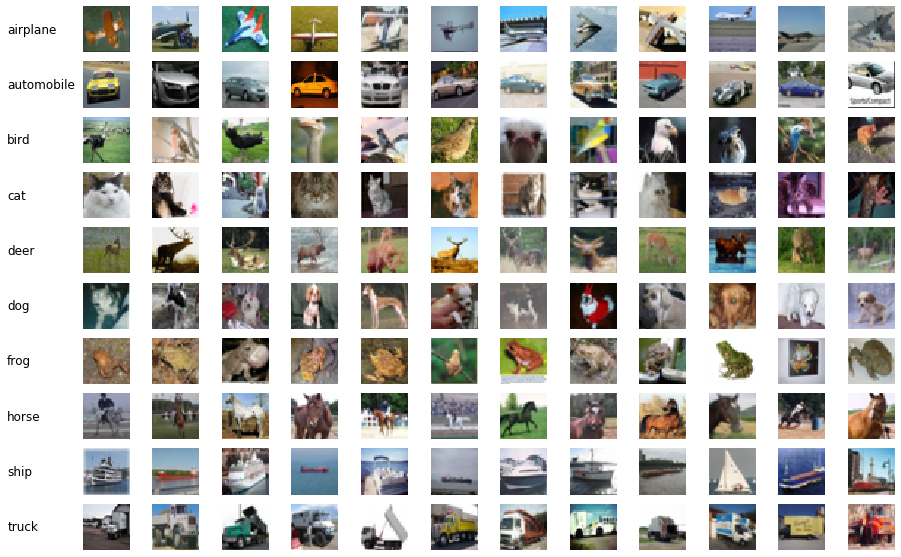

In [3]:
n_imgs = 12
labels = np.unique(y_train0)

fig0, axs = plt.subplots(nrows=len(labels), ncols=n_imgs + 1, figsize=(16, len(labels)))
for (xlabel, xcat, xaxs) in zip(labels, categories, axs):
    xaxs[0].text(0, 0.5, xcat, fontsize=12, va='center')
    xaxs[0].axis('off')
    idxs = np.random.choice(np.argwhere(y_train0 == xlabel).ravel(), n_imgs, replace=False)
    
    for (idx, xax) in zip(idxs, xaxs[1:]):
        xax.imshow(X_train0[idx])
        xax.set_aspect('equal')
        xax.axis('off')

Ok, due to low resolution some pics are pretty hard to get, even for human eye. Hope that neural net will do better than me.

As usual, we pick some data randomly from training set to serve as validation data.

In [4]:
val_part = 0.25
val_num = int(val_part*X_train0.shape[0])
tot_idxs = np.random.permutation(np.arange(X_train0.shape[0]))

val_idxs = tot_idxs[:val_num]
train_idxs = tot_idxs[val_num:]

## Setting up PyTorch

I will use my GPU to work on this project.

In [5]:
assert torch.cuda.is_available()
GPU = torch.device('cuda: 0')

Placeholders for different models training histories.

In [6]:
tr_loss = {}
val_loss = {}
val_acc = {}
test_acc = {}

Although we're working with images here - we won't be using any image-specific tools and data augmentations, so simple `TensorDataset` would be enough. One note: Torch prefers images to have dimensions as ($B$, $C$, $H$, $W$), so we need to transpose axes a little.

In [7]:
X_train_norm_torch = torch.from_numpy(X_train_norm.transpose((0, 3, 1, 2))).type(torch.float)
y_train_torch = torch.from_numpy(y_train0).type(torch.LongTensor)
X_test_norm_torch = torch.from_numpy(X_test_norm.transpose((0, 3, 1, 2))).type(torch.float)
y_test_torch = torch.from_numpy(np.array(y_test0)).type(torch.LongTensor)

train_dset = TensorDataset(X_train_norm_torch[train_idxs], y_train_torch[train_idxs])
val_dset = TensorDataset(X_train_norm_torch[val_idxs], y_train_torch[val_idxs])
test_dset = TensorDataset(X_test_norm_torch, y_test_torch)

Prepare data loaders.

In [8]:
train_loader = DataLoader(train_dset, batch_size=128, 
                          sampler=RandomSampler(train_dset))
val_loader = DataLoader(val_dset, batch_size=128, 
                        sampler=RandomSampler(val_dset))
test_loader = DataLoader(test_dset, batch_size=128, 
                         sampler=SequentialSampler(test_dset))

Helper class that we use to pass from convolutional layers to fully-connected. All it does is just flattening tensor into 2 dimensions: batch and features.

In [9]:
class Flattener(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, X):
        return X.view(X.shape[0], -1)

## Training torch models

Here we build and test several models, trying to reach our goal - get $70\%$ accuracy on test dataset.

### Torch model 1.

As usual, first model is very simple. Just one 3x3 convolution followed by max pooling, and then we flatten and pass it to two-layers linear classificator. Also, BatchNorms and Dropouts are added to reduce overfitting.

In [10]:
model_torch1 = nn.Sequential(
    # 3 x 32 x 32
    nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1), 
    # 32 x 32 x 32
    nn.MaxPool2d(kernel_size=5, stride=3), 
    # 32 x 10 x 10
    nn.ReLU(), 
    nn.BatchNorm2d(num_features=32), 
    nn.Dropout(p=0.2), 
    Flattener(), 
    # 3200
    nn.Linear(in_features=3200, out_features=512, bias=False), 
    # 512
    nn.BatchNorm1d(num_features=512), 
    nn.Dropout(p=0.5),
    nn.ReLU(), 
    nn.Linear(in_features=512, out_features=10)
    # 10
)

Moving model to GPU.

In [11]:
model_torch1.type(torch.cuda.FloatTensor)
model_torch1.to(GPU)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): MaxPool2d(kernel_size=5, stride=3, padding=0, dilation=1, ceil_mode=False)
  (2): ReLU()
  (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Dropout(p=0.2)
  (5): Flattener()
  (6): Linear(in_features=3200, out_features=512, bias=False)
  (7): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): Dropout(p=0.5)
  (9): ReLU()
  (10): Linear(in_features=512, out_features=10, bias=True)
)

#### Training

Let's check how model initializes. We expect to see accuracy of around $10\%$ and log-loss of around $\log{10} \approx 2.30$.

In [67]:
init_check = initial_model_check(model_torch1, train_loader, val_loader, 
                                 device=GPU, metric=accuracy)
tr_loss[1] = [init_check[0]]
val_loss[1] = [init_check[1]]
val_acc[1] = [init_check[2]]

Model loss on train set: 2.309
Model loss on validation set: 2.308
Model metric on validation set set: 0.09960


Very good.

I intentionally skip overfitting to small dataset here. It does overfit though, I tried it.

All right. Initialize all the necessary components: loss function, optimizer and learning rate scheduler and get on with training. We will train for 24 epochs, gradually decreasing learning rate.

In [68]:
loss_fct = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(model_torch1.parameters(), lr=1e-4, weight_decay=1e-3)
lr_sch = torch.optim.lr_scheduler.StepLR(opt, gamma=0.8, step_size=3)

tr_res = train_torch(model_torch1, GPU, train_loader, val_loader, 
                     loss_fct, opt, lr_sch, accuracy, 
                     num_epochs=24, verbose=True, show_progress=True, 
                     delay=0)

tr_loss[1] += tr_res[0]
val_loss[1] += tr_res[1]
val_acc[1] += tr_res[2]

--------------------------------
Epoch 1/24
--------------------------------


Training pass over. Loss: 1.6613923888270061
Validation loss: 1.4131069869613648
Validation metric: 0.53456


--------------------------------
Epoch 2/24
--------------------------------


Training pass over. Loss: 1.347129753672282
Validation loss: 1.2354229666519165
Validation metric: 0.58128


--------------------------------
Epoch 3/24
--------------------------------


Training pass over. Loss: 1.2114370189412436
Validation loss: 1.1388112161636352
Validation metric: 0.61264


--------------------------------
Epoch 4/24
--------------------------------


Training pass over. Loss: 1.1237957803090413
Validation loss: 1.0858292106246947
Validation metric: 0.62584


--------------------------------
Epoch 5/24
--------------------------------


Training pass over. Loss: 1.0667786026382446
Validation loss: 1.0398434972000121
Validation metric: 0.64384


--------------------------------
Epoch 6/24
--------------------------------


Training pass over. Loss: 1.024988978246053
Validation loss: 1.0129542887496947
Validation metric: 0.6532


--------------------------------
Epoch 7/24
--------------------------------


Training pass over. Loss: 0.9878865800221761
Validation loss: 0.987161736278534
Validation metric: 0.66192


--------------------------------
Epoch 8/24
--------------------------------


Training pass over. Loss: 0.9579795388412475
Validation loss: 0.9729749120140075
Validation metric: 0.66776


--------------------------------
Epoch 9/24
--------------------------------


Training pass over. Loss: 0.9379951120885214
Validation loss: 0.9564797331237793
Validation metric: 0.6704


--------------------------------
Epoch 10/24
--------------------------------


Training pass over. Loss: 0.916556342347463
Validation loss: 0.9425862312316895
Validation metric: 0.67616


--------------------------------
Epoch 11/24
--------------------------------


Training pass over. Loss: 0.8935629534848532
Validation loss: 0.9308650728607177
Validation metric: 0.67992


--------------------------------
Epoch 12/24
--------------------------------


Training pass over. Loss: 0.8846395753415426
Validation loss: 0.9246759606742859
Validation metric: 0.67936


--------------------------------
Epoch 13/24
--------------------------------


Training pass over. Loss: 0.8632262229410808
Validation loss: 0.9172228552246093
Validation metric: 0.68488


--------------------------------
Epoch 14/24
--------------------------------


Training pass over. Loss: 0.8528179121843974
Validation loss: 0.9091094336700439
Validation metric: 0.68792


--------------------------------
Epoch 15/24
--------------------------------


Training pass over. Loss: 0.8436522607994079
Validation loss: 0.9047417280387878
Validation metric: 0.68936


--------------------------------
Epoch 16/24
--------------------------------


Training pass over. Loss: 0.8268638444709778
Validation loss: 0.8965055482673645
Validation metric: 0.6924


--------------------------------
Epoch 17/24
--------------------------------


Training pass over. Loss: 0.8221665354792277
Validation loss: 0.8943852172279357
Validation metric: 0.69216


--------------------------------
Epoch 18/24
--------------------------------


Training pass over. Loss: 0.8098432352129619
Validation loss: 0.8881779176139831
Validation metric: 0.6952


--------------------------------
Epoch 19/24
--------------------------------


Training pass over. Loss: 0.8055143919499715
Validation loss: 0.8838288648986816
Validation metric: 0.6952


--------------------------------
Epoch 20/24
--------------------------------


Training pass over. Loss: 0.7955669042460124
Validation loss: 0.8825024291419983
Validation metric: 0.69888


--------------------------------
Epoch 21/24
--------------------------------


Training pass over. Loss: 0.7881042103131612
Validation loss: 0.8797064999389649
Validation metric: 0.6972


--------------------------------
Epoch 22/24
--------------------------------


Training pass over. Loss: 0.7814649097251892
Validation loss: 0.8757295106124878
Validation metric: 0.70008


--------------------------------
Epoch 23/24
--------------------------------


Training pass over. Loss: 0.7798058776346842
Validation loss: 0.8748478295898438
Validation metric: 0.7004


--------------------------------
Epoch 24/24
--------------------------------


Training pass over. Loss: 0.7700873565800985
Validation loss: 0.8715528382492066
Validation metric: 0.70168




The results are significantly better than with fully connected layers only. Even the simplest model got us to $70\%$ accuracy on validation, even if only by a tiny margin. Fantastic.

Let's see the training history.

Model 1 accuracy on test set: 70.09%


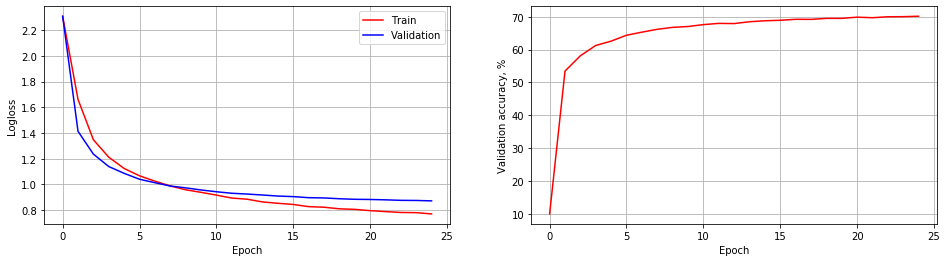

In [69]:
visualize_training(tr_loss[1], val_loss[1], val_acc[1])

The curves look very good - I see no ovefitting, and we got above $70\%$ accuracy on validation set.

#### Saving/loading model

In [13]:
#torch.save(model_torch1.state_dict(), os.path.join('.', 'model_torch1_weights'))
model_torch1.load_state_dict(torch.load(os.path.join('.', 'model_torch1_weights')))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

#### Performance analysis

No overfitting, looks quite nice, and I believe if we continue with training - we might get another $1\%$ of accuracy. Also, $70\%$ is beaten on test set as well.

Let's analyze our model performance a little. Accuracy is very intuitive, but unfortunately not very informative metric. It takes into account only hard predictions (class with largest probability), but what if out model is not sure of its prediction? Let's see how probability of selected class is distributed when model depending on whether our model is correct or not.

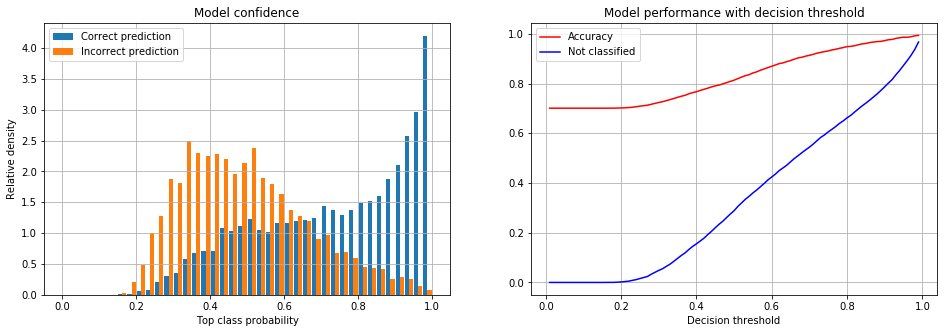

In [102]:
predX, gt, _ = predict_torch(model_torch1, test_loader, GPU)
predX = predX.numpy()
gt = gt.numpy()
print('Test set accuracy: {0:.1f}%'.format(100*accuracy(gt, predX.argmax(axis=1))))
visualize_prediction_confidence(predX, gt)

Aha. So, our model tends to be pretty sure when it is correct, and not so sure when it is wrong. Second graph shows how our accuracy increases when we employ desicion threshold - we take no decision if largest class probability is below certain number.

Let's see where our model is wrong the most.

In [103]:
cm = confusion_matrix(gt, predX.argmax(axis=1))

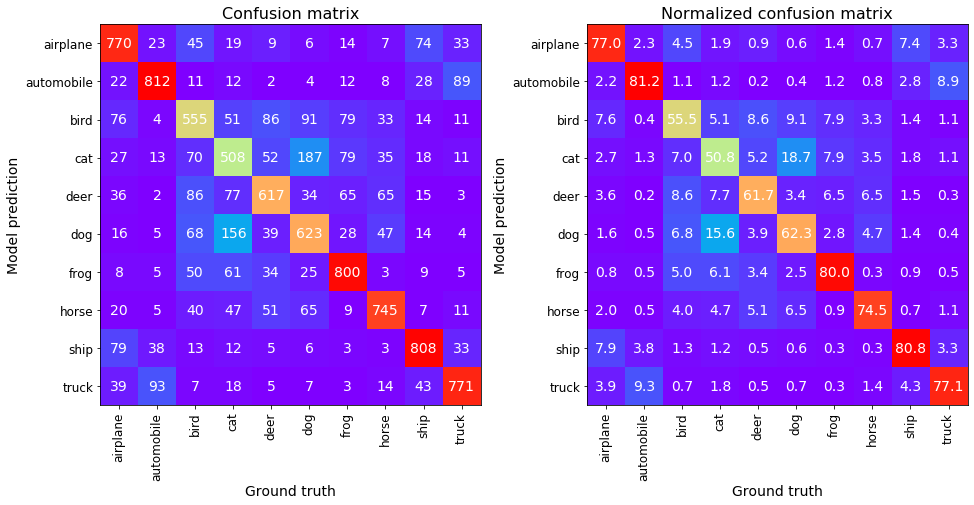

In [104]:
fig0, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 7))

axs[0].imshow(cm, cmap='rainbow')
for ipred in range(cm.shape[0]):
    for igt in range(cm.shape[1]):
        axs[0].text(ipred, igt, cm[ipred, igt], 
                    ha='center', va='center', color='white', fontsize=14)
        
axs[0].set_xlabel('Ground truth', fontsize=14)
axs[0].set_ylabel('Model prediction', fontsize=14)
axs[0].set_xticks(range(len(labels)))
axs[0].set_yticks(range(len(labels)))
_ = axs[0].set_xticklabels(categories, rotation='vertical', fontsize=12)
_ = axs[0].set_yticklabels(categories, fontsize=12)
_ = axs[0].set_title('Confusion matrix', fontsize=16)

# ================

axs[1].imshow(cm, cmap='rainbow')
for ipred in range(cm.shape[0]):
    for igt in range(cm.shape[1]):
        axs[1].text(ipred, igt, np.round(100*cm[ipred, igt]/cm[:, igt].sum(), 1), 
                    ha='center', va='center', color='white', fontsize=14)
        
axs[1].set_xlabel('Ground truth', fontsize=14)
axs[1].set_ylabel('Model prediction', fontsize=14)
axs[1].set_xticks(range(len(labels)))
axs[1].set_yticks(range(len(labels)))
_ = axs[1].set_xticklabels(categories, rotation='vertical', fontsize=12)
_ = axs[1].set_yticklabels(categories, fontsize=12)
_ = axs[1].set_title('Normalized confusion matrix', fontsize=16)

#### Visualizing model errors

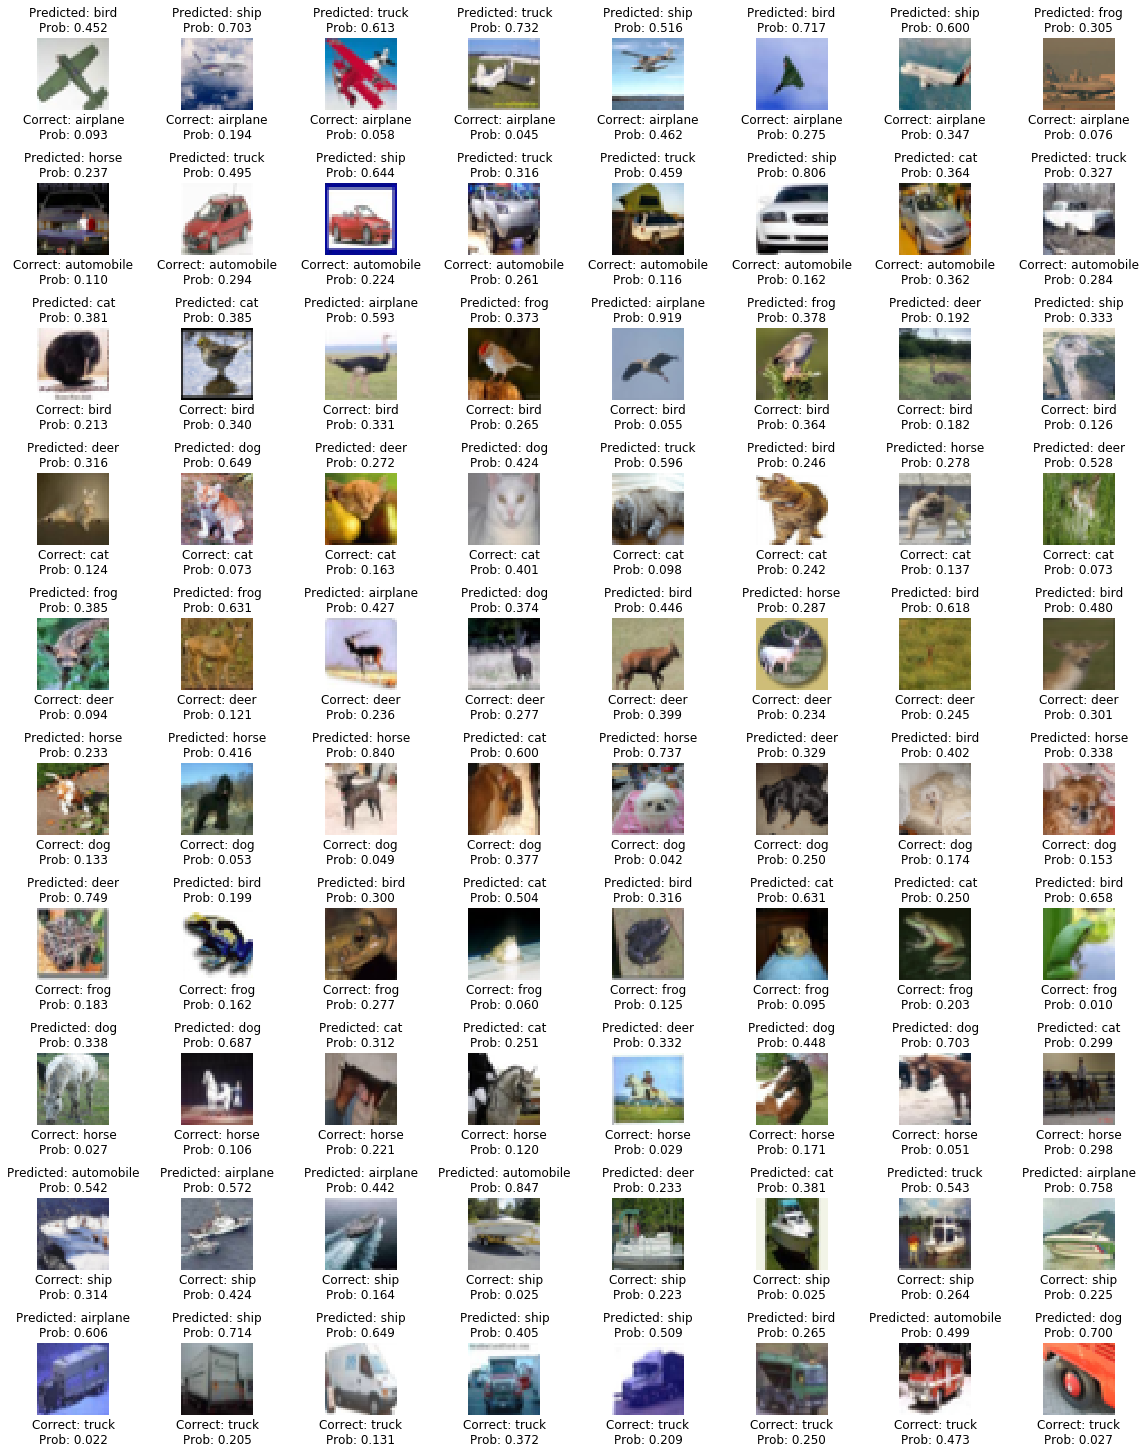

In [127]:
n_per_class = 8

fig0, axs = plt.subplots(nrows=len(categories), ncols=n_per_class, 
                         figsize=(16, 2*len(categories)))
for (igt, xcat) in enumerate(categories):
    idxs = np.random.choice(np.nonzero((gt == igt) & (predX.argmax(axis=1) != gt))[0], 
                            n_per_class, replace=False)
    
    for ((ipred, idx), xax) in zip(enumerate(idxs), axs[igt]):
        xax.imshow(X_test0[idx])
        xax.set_xlabel('\n'.join([
            f'Correct: {xcat}', 
            'Prob: {0:.3f}'.format(predX[idx, igt])]), fontsize=12)
        xax.set_title('\n'.join([
            f'Predicted: {categories[predX[idx].argmax()]}', 
            'Prob: {0:.3f}'.format(predX[idx].max())]), fontsize=12)
        #xax.axis('off')
        
        xax.spines['top'].set_visible(False)
        xax.spines['bottom'].set_visible(False)
        xax.spines['left'].set_visible(False)
        xax.spines['right'].set_visible(False)
        
        xax.set_xticks([])
        xax.set_yticks([])
        
plt.tight_layout(pad=0.0, h_pad=1.0, w_pad=0.0)

### Torch model 2.

In [128]:
model_torch2 = nn.Sequential(
    # 3 x 32 x 32
    nn.Conv2d(in_channels=3, out_channels=12, kernel_size=5, stride=1, padding=0), 
    # 12 x 28 x 28
    nn.MaxPool2d(kernel_size=2, stride=2), 
    # 12 x 14 x 14
    nn.ReLU(), 
    nn.BatchNorm2d(num_features=12), 
    nn.Dropout(p=0.2), 
    nn.Conv2d(in_channels=12, out_channels=48, kernel_size=5, stride=1, padding=0), 
    # 48 x 10 x 10
    nn.MaxPool2d(kernel_size=2, stride=2), 
    # 48 x 5 x 5
    nn.ReLU(), 
    nn.BatchNorm2d(num_features=48), 
    nn.Dropout(p=0.2), 
    Flattener(), 
    # 1200
    nn.Linear(in_features=1200, out_features=128, bias=False), 
    # 128
    nn.ReLU(), 
    nn.BatchNorm1d(num_features=128), 
    nn.Dropout(p=0.5), 
    nn.Linear(in_features=128, out_features=10)
    # 10
)

Moving model to GPU.

In [129]:
model_torch2.type(torch.cuda.FloatTensor)
model_torch2.to(GPU)

Sequential(
  (0): Conv2d(3, 12, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): ReLU()
  (3): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Dropout(p=0.2)
  (5): Conv2d(12, 48, kernel_size=(5, 5), stride=(1, 1))
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): ReLU()
  (8): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Dropout(p=0.2)
  (10): Flattener()
  (11): Linear(in_features=1200, out_features=128, bias=False)
  (12): ReLU()
  (13): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): Dropout(p=0.5)
  (15): Linear(in_features=128, out_features=10, bias=True)
)

#### Training

Let's check how PyTorch model initializes.

In [156]:
init_check = initial_model_check(model_torch2, train_loader, val_loader, 
                                 device=GPU, metric=accuracy)
tr_loss[2] = [init_check[0]]
val_loss[2] = [init_check[1]]
val_acc[2] = [init_check[2]]

Model loss on train set: 2.304
Model loss on validation set: 2.304
Model metric on validation set set: 0.10768


Indeed I have to revisit my initialization strategy. This one is close to perfect.

All right. Initialize all the necessary components and get on with training. We will train for 40 epochs.

In [157]:
loss_fct = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(model_torch2.parameters(), lr=1e-3, weight_decay=1e-3)
lr_sch = torch.optim.lr_scheduler.StepLR(opt, gamma=0.8, step_size=3)

tr_res = train_torch(model_torch2, GPU, train_loader, val_loader, 
                     loss_fct, opt, lr_sch, accuracy, 
                     num_epochs=24, verbose=True, show_progress=True, 
                     delay=5)

tr_loss[2] += tr_res[0]
val_loss[2] += tr_res[1]
val_acc[2] += tr_res[2]

--------------------------------
Epoch 1/24
--------------------------------


Training pass over. Loss: 1.5504534095001221
Validation loss: 1.2586786320114136
Validation metric: 0.55248


Delay for 5 seconds
--------------------------------
Epoch 2/24
--------------------------------


Training pass over. Loss: 1.2333797812016805
Validation loss: 1.126567350883484
Validation metric: 0.59928


Delay for 5 seconds
--------------------------------
Epoch 3/24
--------------------------------


Training pass over. Loss: 1.1252999236297607
Validation loss: 1.024337389602661
Validation metric: 0.63728


Delay for 5 seconds
--------------------------------
Epoch 4/24
--------------------------------


Training pass over. Loss: 1.0428509455362955
Validation loss: 0.9746253942871094
Validation metric: 0.6496


Delay for 5 seconds
--------------------------------
Epoch 5/24
--------------------------------


Training pass over. Loss: 0.99253398630778
Validation loss: 0.9413100664520264
Validation metric: 0.66512


Delay for 5 seconds
--------------------------------
Epoch 6/24
--------------------------------


Training pass over. Loss: 0.9637285327657064
Validation loss: 0.9058973253059387
Validation metric: 0.67744


Delay for 5 seconds
--------------------------------
Epoch 7/24
--------------------------------


Training pass over. Loss: 0.9221178667640686
Validation loss: 0.8804474586486817
Validation metric: 0.6892


Delay for 5 seconds
--------------------------------
Epoch 8/24
--------------------------------


Training pass over. Loss: 0.9003557831128438
Validation loss: 0.8718615753746033
Validation metric: 0.6932


Delay for 5 seconds
--------------------------------
Epoch 9/24
--------------------------------


Training pass over. Loss: 0.8837044904009501
Validation loss: 0.8490509355354309
Validation metric: 0.70088


Delay for 5 seconds
--------------------------------
Epoch 10/24
--------------------------------


Training pass over. Loss: 0.8496408050664266
Validation loss: 0.8411592640686035
Validation metric: 0.70864


Delay for 5 seconds
--------------------------------
Epoch 11/24
--------------------------------


Training pass over. Loss: 0.8410493527539571
Validation loss: 0.8359014851760864
Validation metric: 0.7068


Delay for 5 seconds
--------------------------------
Epoch 12/24
--------------------------------


Training pass over. Loss: 0.8223493016370138
Validation loss: 0.8094918414497375
Validation metric: 0.71176


Delay for 5 seconds
--------------------------------
Epoch 13/24
--------------------------------


Training pass over. Loss: 0.7997343826611837
Validation loss: 0.7980794029998779
Validation metric: 0.71616


Delay for 5 seconds
--------------------------------
Epoch 14/24
--------------------------------


Training pass over. Loss: 0.788928328183492
Validation loss: 0.7813782431030274
Validation metric: 0.72328


Delay for 5 seconds
--------------------------------
Epoch 15/24
--------------------------------


Training pass over. Loss: 0.7786113094774882
Validation loss: 0.7836852442932128
Validation metric: 0.72616


Delay for 5 seconds
--------------------------------
Epoch 16/24
--------------------------------


Training pass over. Loss: 0.767322045618693
Validation loss: 0.7775225750923157
Validation metric: 0.72704


Delay for 5 seconds
--------------------------------
Epoch 17/24
--------------------------------


Training pass over. Loss: 0.7564631174023946
Validation loss: 0.7745265007019043
Validation metric: 0.72776


Delay for 5 seconds
--------------------------------
Epoch 18/24
--------------------------------


Training pass over. Loss: 0.745977852045695
Validation loss: 0.7804425860214234
Validation metric: 0.73016


Delay for 5 seconds
--------------------------------
Epoch 19/24
--------------------------------


Training pass over. Loss: 0.7330123604393005
Validation loss: 0.7606023652839661
Validation metric: 0.73368


Delay for 5 seconds
--------------------------------
Epoch 20/24
--------------------------------


Training pass over. Loss: 0.731521980342865
Validation loss: 0.7626146364021301
Validation metric: 0.7336


Delay for 5 seconds
--------------------------------
Epoch 21/24
--------------------------------


Training pass over. Loss: 0.7166561587842305
Validation loss: 0.7627045092773438
Validation metric: 0.73


Delay for 5 seconds
--------------------------------
Epoch 22/24
--------------------------------


Training pass over. Loss: 0.7123356453641255
Validation loss: 0.7570013938331605
Validation metric: 0.73536


Delay for 5 seconds
--------------------------------
Epoch 23/24
--------------------------------


Training pass over. Loss: 0.708002343120575
Validation loss: 0.749804467754364
Validation metric: 0.73864


Delay for 5 seconds
--------------------------------
Epoch 24/24
--------------------------------


Training pass over. Loss: 0.7003784392929077
Validation loss: 0.7424627472114563
Validation metric: 0.74096


Delay for 5 seconds


Results are quite better. Let's see the graphs.

Model 1 accuracy on test set: 73.88%


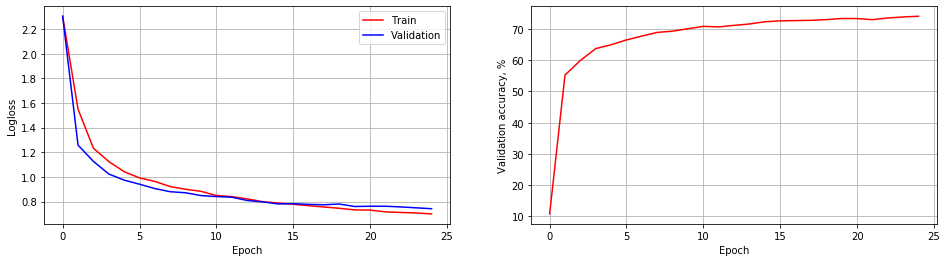

In [158]:
visualize_training(tr_loss[2], val_loss[2], val_acc[2])

#### Saving/loading model

In [130]:
#torch.save(model_torch2.state_dict(), os.path.join('.', 'model_torch2_weights'))
model_torch2.load_state_dict(torch.load(os.path.join('.', 'model_torch2_weights')))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

#### Performance analysis

Test set accuracy: 73.9%


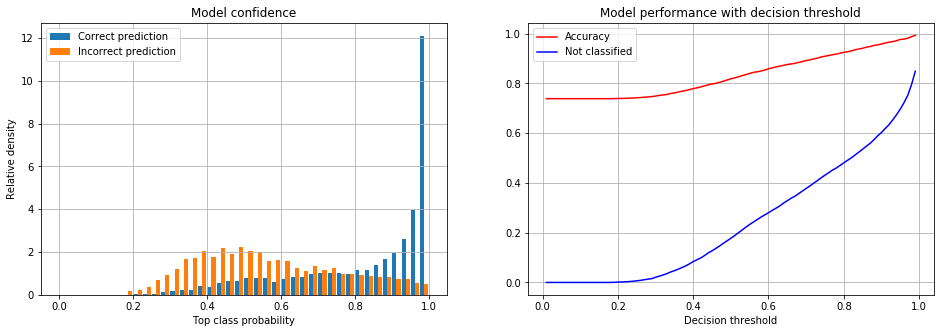

In [132]:
predX, gt, _ = predict_torch(model_torch2, test_loader, GPU)
predX = predX.numpy()
gt = gt.numpy()
print('Test set accuracy: {0:.1f}%'.format(100*accuracy(gt, predX.argmax(axis=1))))
visualize_prediction_confidence(predX, gt)

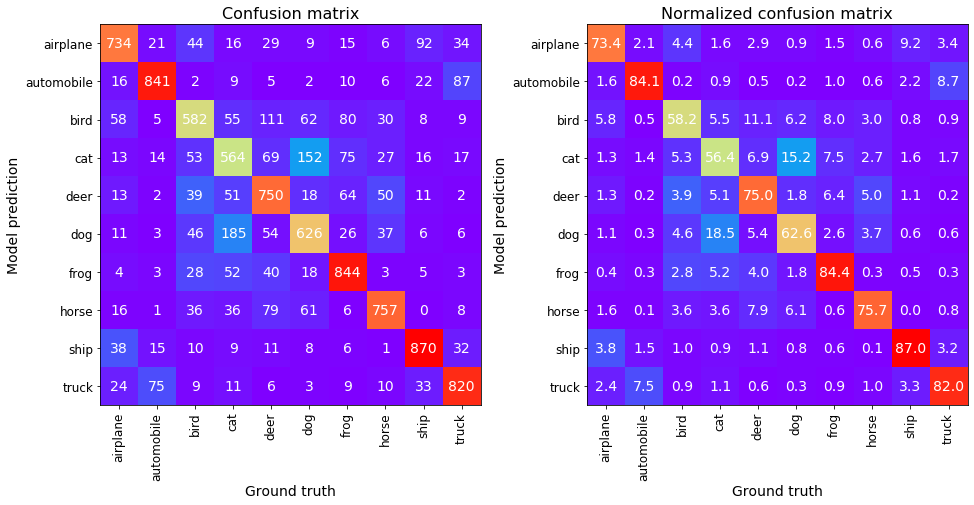

In [134]:
cm = confusion_matrix(gt, predX.argmax(axis=1))
visualize_confusion_matrix(cm, categories)

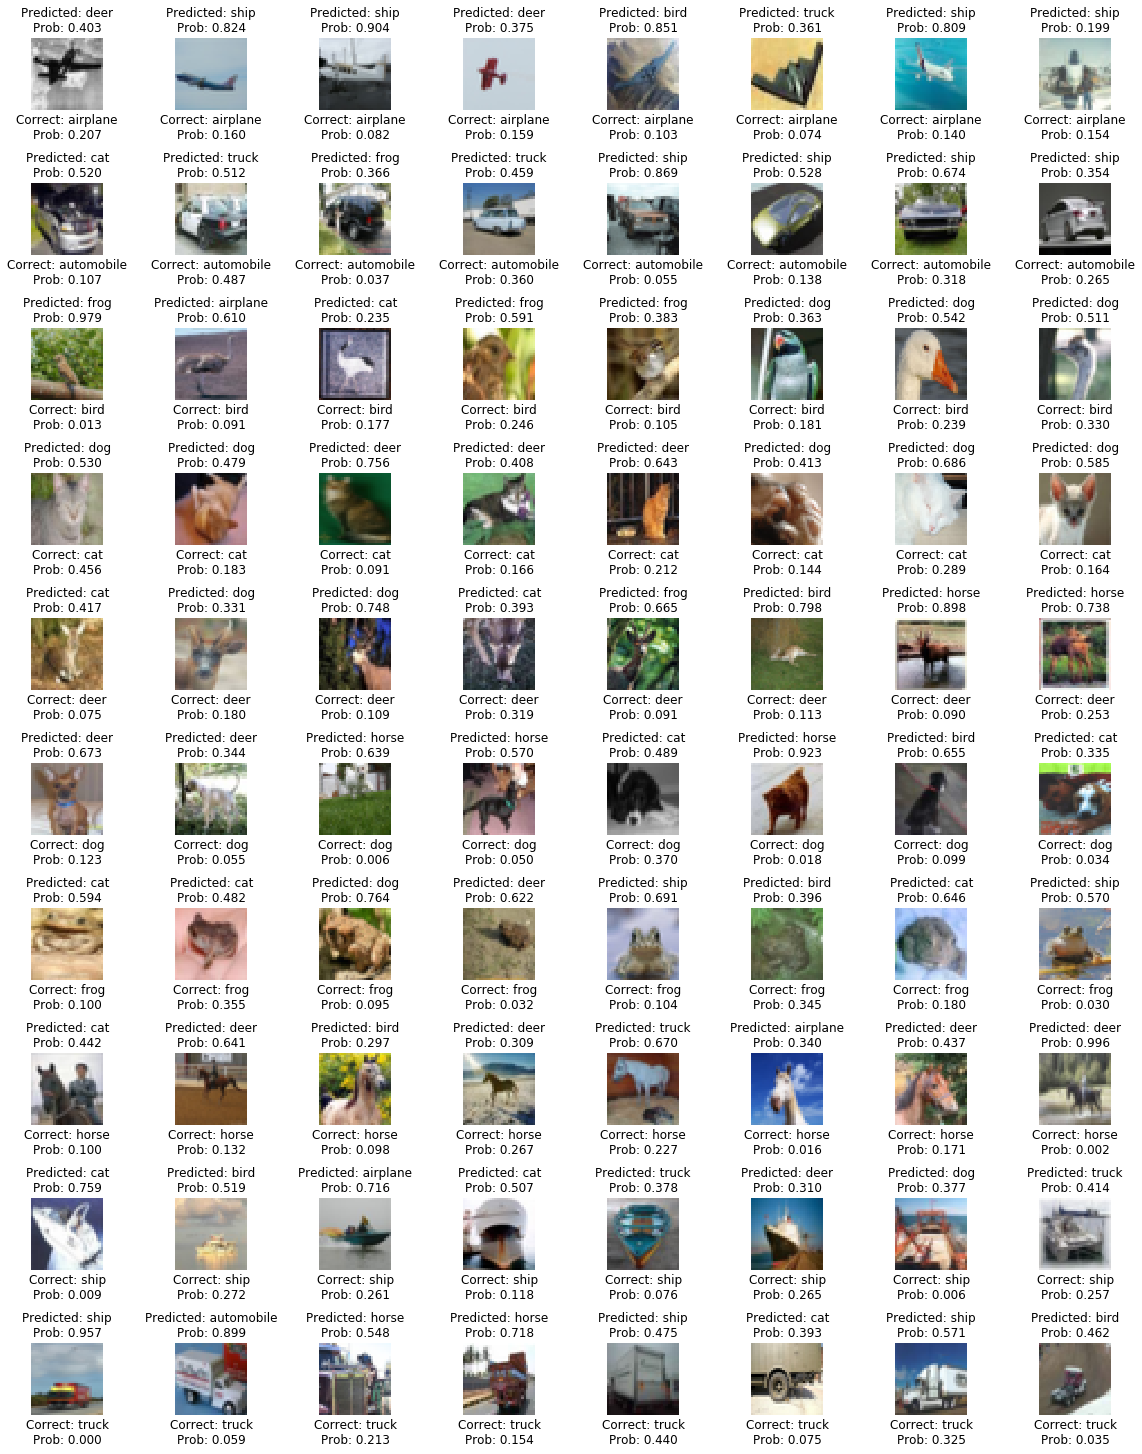

In [136]:
visualize_errors(predX, gt, X_test0, categories, 8)

### Torch model 3.

In [137]:
class ResBlock(nn.Module):
    def __init__(self, kernel_size, channels):
        super().__init__()
        self.resblock = nn.Sequential(
            nn.Conv2d(kernel_size=kernel_size, in_channels=channels, out_channels=channels, 
                      padding=(kernel_size - 1)//2), 
            nn.ReLU(), 
            nn.Conv2d(kernel_size=kernel_size, in_channels=channels, out_channels=channels, 
                      padding=(kernel_size - 1)//2)
        )
        
    def forward(self, X):
        return X + self.resblock.forward(X)

In [138]:
model_torch3 = nn.Sequential(
    # 3 x 32 x 32
    nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=1, padding=0), 
        # 64 x 26 x 26
        ResBlock(kernel_size=3, channels=64), 
        nn.BatchNorm2d(num_features=64), 
        nn.Dropout(p=0.1), 
    ), 
    # ----------------------------------------------------------------
    nn.Sequential(
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=7, stride=1, padding=0), 
        # 64 x 20 x 20
        ResBlock(kernel_size=3, channels=64), 
        nn.BatchNorm2d(num_features=64), 
        nn.Dropout(p=0.1), 
    ), 
    # ----------------------------------------------------------------
    nn.Sequential(
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=7, stride=1, padding=0), 
        # 128 x 14 x 14
        ResBlock(kernel_size=3, channels=128), 
        nn.BatchNorm2d(num_features=128), 
        nn.Dropout(p=0.1), 
    ), 
    # ----------------------------------------------------------------
    nn.Sequential(
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=7, stride=1, padding=0), 
        # 256 x 8 x 8
        ResBlock(kernel_size=3, channels=256), 
        nn.BatchNorm2d(num_features=256), 
        nn.Dropout(p=0.1), 
    ), 
    # ----------------------------------------------------------------
    nn.Sequential(
        nn.AvgPool2d(kernel_size=4, stride=2), 
        # 256 x 3 x 3
        Flattener(), 
        # 2304
        nn.Linear(in_features=2304, out_features=256), 
        # 256
        nn.ReLU(), 
        nn.BatchNorm1d(num_features=256), 
        nn.Dropout(p=0.5), 
        nn.Linear(in_features=256, out_features=10)
    )
    # 10
)

Moving model to GPU.

In [139]:
model_torch3.type(torch.cuda.FloatTensor)
model_torch3.to(GPU)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (1): ResBlock(
      (resblock): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1)
  )
  (1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1))
    (1): ResBlock(
      (resblock): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1)
  )
  (2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1))
    (1): ResBlock(
      (resblock): S

#### Training

Let's check how PyTorch model initializes.

In [150]:
init_check = initial_model_check(model_torch3, train_loader, val_loader, 
                                 device=GPU, metric=accuracy)
tr_loss[3] = [init_check[0]]
val_loss[3] = [init_check[1]]
val_acc[3] = [init_check[2]]

Model loss on train set: 2.303
Model loss on validation set: 2.304
Model metric on validation set set: 0.09680


Indeed I have to revisit my initialization strategy. This one is close to perfect.

All right. Initialize all the necessary components and get on with training. We will train for 40 epochs.

In [151]:
loss_fct = torch.nn.CrossEntropyLoss()

opt = torch.optim.Adam(model_torch3.parameters(), lr=1e-3, weight_decay=1e-2)
#lr_sch = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=2, factor=0.5, verbose=True)
lr_sch = torch.optim.lr_scheduler.MultiStepLR(opt, milestones=[3, 6, 10, 15, 21], gamma=0.5)

tr_res = train_torch(model_torch3, GPU, train_loader, val_loader, 
                     loss_fct, opt, lr_sch, accuracy, 
                     num_epochs=24, verbose=True, show_progress=True, 
                     delay=30)

tr_loss[3] += tr_res[0]
val_loss[3] += tr_res[1]
val_acc[3] += tr_res[2]

--------------------------------
Epoch 1/24
--------------------------------


Training pass over. Loss: 1.807017843208313
Validation loss: 1.8120196603775025
Validation metric: 0.3224


Delay for 30 seconds
--------------------------------
Epoch 2/24
--------------------------------


Training pass over. Loss: 1.6018108103815714
Validation loss: 1.6183055298233031
Validation metric: 0.40872


Delay for 30 seconds
--------------------------------
Epoch 3/24
--------------------------------


Training pass over. Loss: 1.5134346878814697
Validation loss: 1.6631754541397095
Validation metric: 0.40904


Delay for 30 seconds
--------------------------------
Epoch 4/24
--------------------------------


Training pass over. Loss: 1.3646115346399943
Validation loss: 1.3761911926651
Validation metric: 0.50128


Delay for 30 seconds
--------------------------------
Epoch 5/24
--------------------------------


Training pass over. Loss: 1.307452800140381
Validation loss: 1.329460310974121
Validation metric: 0.51856


Delay for 30 seconds
--------------------------------
Epoch 6/24
--------------------------------


Training pass over. Loss: 1.264935382156372
Validation loss: 1.236043196144104
Validation metric: 0.55896


Delay for 30 seconds
--------------------------------
Epoch 7/24
--------------------------------


Training pass over. Loss: 1.1619435620880127
Validation loss: 1.1626630435562133
Validation metric: 0.58352


Delay for 30 seconds
--------------------------------
Epoch 8/24
--------------------------------


Training pass over. Loss: 1.1245287219492595
Validation loss: 1.1285934357833862
Validation metric: 0.5948


Delay for 30 seconds
--------------------------------
Epoch 9/24
--------------------------------


Training pass over. Loss: 1.0968831458791097
Validation loss: 1.0860421802902223
Validation metric: 0.61592


Delay for 30 seconds
--------------------------------
Epoch 10/24
--------------------------------


Training pass over. Loss: 1.0658507417551677
Validation loss: 1.0380261531829833
Validation metric: 0.63416


Delay for 30 seconds
--------------------------------
Epoch 11/24
--------------------------------


Training pass over. Loss: 0.9845999572181702
Validation loss: 1.0117725541496276
Validation metric: 0.6436


Delay for 30 seconds
--------------------------------
Epoch 12/24
--------------------------------


Training pass over. Loss: 0.9598503453890482
Validation loss: 0.964575171661377
Validation metric: 0.6624


Delay for 30 seconds
--------------------------------
Epoch 13/24
--------------------------------


Training pass over. Loss: 0.9388051579666138
Validation loss: 0.9347514594650268
Validation metric: 0.67368


Delay for 30 seconds
--------------------------------
Epoch 14/24
--------------------------------


Training pass over. Loss: 0.9161722918256124
Validation loss: 0.9260487482261658
Validation metric: 0.67472


Delay for 30 seconds
--------------------------------
Epoch 15/24
--------------------------------


Training pass over. Loss: 0.8973039889907837
Validation loss: 0.897381870098114
Validation metric: 0.684


Delay for 30 seconds
--------------------------------
Epoch 16/24
--------------------------------


Training pass over. Loss: 0.8415575266265869
Validation loss: 0.8652113504219056
Validation metric: 0.69448


Delay for 30 seconds
--------------------------------
Epoch 17/24
--------------------------------


Training pass over. Loss: 0.8215467699432373
Validation loss: 0.8491400567054749
Validation metric: 0.70208


Delay for 30 seconds
--------------------------------
Epoch 18/24
--------------------------------


Training pass over. Loss: 0.8104723357582092
Validation loss: 0.8385831426239013
Validation metric: 0.71008


Delay for 30 seconds
--------------------------------
Epoch 19/24
--------------------------------


Training pass over. Loss: 0.7988509730466207
Validation loss: 0.8486574981880188
Validation metric: 0.7036


Delay for 30 seconds
--------------------------------
Epoch 20/24
--------------------------------


Training pass over. Loss: 0.787908711681366
Validation loss: 0.8256579602050781
Validation metric: 0.71352


Delay for 30 seconds
--------------------------------
Epoch 21/24
--------------------------------


Training pass over. Loss: 0.7740349395052591
Validation loss: 0.8236779509162903
Validation metric: 0.71168


Delay for 30 seconds
--------------------------------
Epoch 22/24
--------------------------------


Training pass over. Loss: 0.742158279469808
Validation loss: 0.7914448077392578
Validation metric: 0.72528


Delay for 30 seconds
--------------------------------
Epoch 23/24
--------------------------------


Training pass over. Loss: 0.7336495238876343
Validation loss: 0.7885967112541199
Validation metric: 0.72704


Delay for 30 seconds
--------------------------------
Epoch 24/24
--------------------------------


Training pass over. Loss: 0.7242832769711812
Validation loss: 0.7840049477958679
Validation metric: 0.72792


Delay for 30 seconds


Results are quite better. Let's see the graphs.

Model 1 accuracy on test set: 73.02%


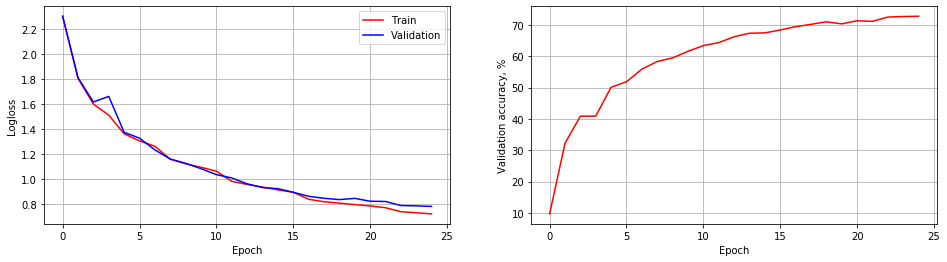

In [152]:
visualize_training(tr_loss[3], val_loss[3], val_acc[3])

#### Saving/loading model

In [140]:
#torch.save(model_torch3.state_dict(), os.path.join('.', 'model_torch3_weights'))
model_torch3.load_state_dict(torch.load(os.path.join('.', 'model_torch3_weights')))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

#### Analyzing performance

Test set accuracy: 73.0%


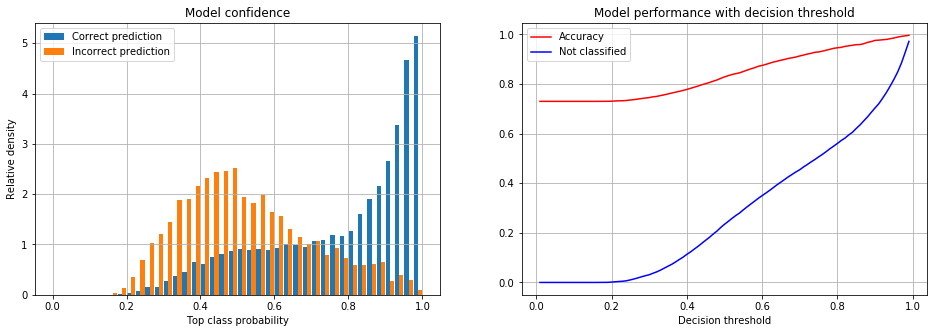

In [141]:
predX, gt, _ = predict_torch(model_torch3, test_loader, GPU)
predX = predX.numpy()
gt = gt.numpy()
print('Test set accuracy: {0:.1f}%'.format(100*accuracy(gt, predX.argmax(axis=1))))
visualize_prediction_confidence(predX, gt)

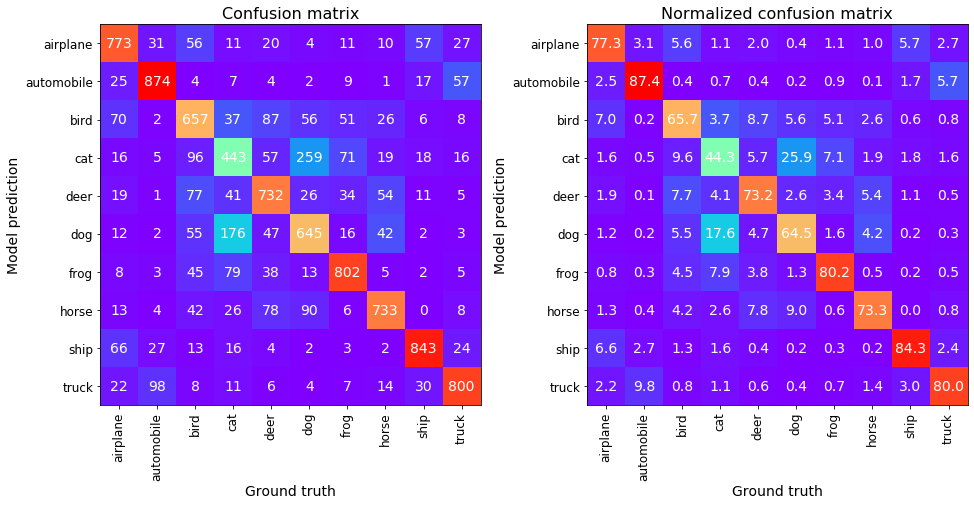

In [142]:
cm = confusion_matrix(gt, predX.argmax(axis=1))
visualize_confusion_matrix(cm, categories)

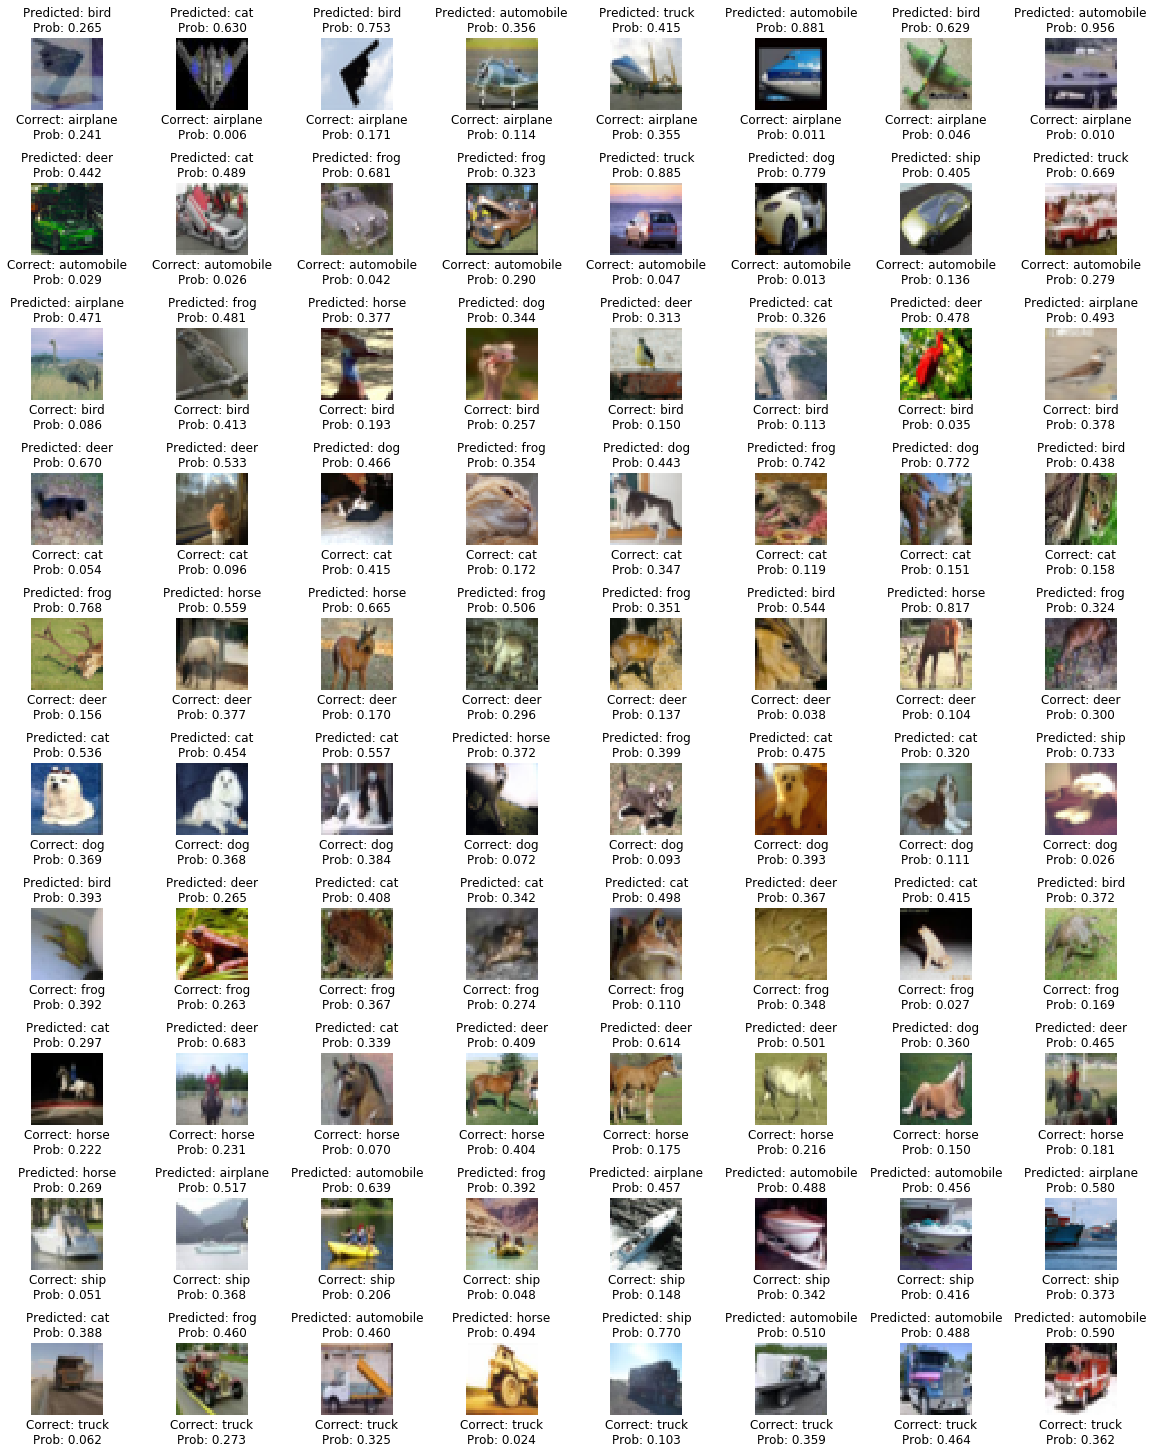

In [143]:
visualize_errors(predX, gt, X_test0, categories, 8)

### Torch model 4.

In [157]:
class ResModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        # ------------------------------------------------
        
        self.convres1 = nn.Sequential(
            # 3 x 32 x 32
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1), 
            # 64 x 16 x 16
            nn.ReLU(), 
            nn.BatchNorm2d(num_features=64), 
            ResBlock(3, 64), 
            nn.ReLU(), 
            nn.BatchNorm2d(num_features=64), 
            ResBlock(3, 64), 
            nn.ReLU(), 
            nn.BatchNorm2d(num_features=64), 
            nn.Dropout(p=0.2),
        )
        self.flattener1 = nn.Sequential(
            # 64 x 16 x 16
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=4), 
            # 64 x 4 x 4
            nn.ReLU(), 
            nn.AvgPool2d(kernel_size=4), 
            # 64 x 1 x 1
            Flattener()
            # 64
        )
        
        # ------------------------------------------------
        
        self.convres2 = nn.Sequential(
            # 64 x 16 x 16
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1), 
            # 128 x 8 x 8
            nn.ReLU(), 
            nn.BatchNorm2d(num_features=128), 
            ResBlock(3, 128), 
            nn.ReLU(), 
            nn.BatchNorm2d(num_features=128), 
            ResBlock(3, 128), 
            nn.ReLU(), 
            nn.BatchNorm2d(num_features=128), 
            nn.Dropout(p=0.2),
            # 128 x 8 x 8
        )
        self.flattener2 = nn.Sequential(
            # 128 x 8 x 8
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=4, stride=4), 
            # 64 x 2 x 2
            nn.ReLU(), 
            nn.AvgPool2d(kernel_size=2), 
            # 64 x 1 x 1
            Flattener()
            # 64
        )
        
        # ------------------------------------------------
        
        self.convres3 = nn.Sequential(
            # 128 x 8 x 8
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1), 
            # 256 x 4 x 4
            nn.ReLU(), 
            nn.BatchNorm2d(num_features=256), 
            ResBlock(3, 256), 
            nn.ReLU(), 
            nn.BatchNorm2d(num_features=256), 
            ResBlock(3, 256), 
            nn.ReLU(), 
            nn.BatchNorm2d(num_features=256), 
            nn.Dropout(p=0.2),
            # 256 x 4 x 4
        )
        self.flattener3 = nn.Sequential(
            # 256 x 4 x 4
            nn.Conv2d(in_channels=256, out_channels=64, kernel_size=4), 
            # 64 x 1 x 1
            nn.ReLU(), 
            # 64 x 1 x 1
            Flattener()
            # 64
        )
        
        # ------------------------------------------------
        
        self.clf = nn.Sequential(
            nn.Linear(in_features=192, out_features=48), 
            nn.ReLU(), 
            nn.BatchNorm1d(num_features=48), 
            nn.Dropout(p=0.5),
            nn.Linear(in_features=48, out_features=10)
        )
        
        
    def forward(self, X):
        X1 = self.convres1.forward(X)
        X1flat = self.flattener1.forward(X1)
        
        X2 = self.convres2.forward(X1)
        X2flat = self.flattener2.forward(X2)
        
        X3 = self.convres3.forward(X2)
        X3flat = self.flattener3(X3)
        
        return self.clf.forward(torch.cat([X1flat, X2flat, X3flat], dim=1))

In [158]:
model_torch4 = ResModel()

In [159]:
model_torch4.type(torch.cuda.FloatTensor)
model_torch4.to(GPU)

RuntimeError: CUDA error: unspecified launch failure

#### Training

In [131]:
init_check = initial_model_check(model_torch4, train_loader, val_loader, 
                                 device=GPU, metric=accuracy)
tr_loss[4] = [init_check[0]]
val_loss[4] = [init_check[1]]
val_acc[4] = [init_check[2]]

Model loss on train set: 2.308
Model loss on validation set: 2.307
Model metric on validation set set: 0.10000


In [132]:
loss_fct = torch.nn.CrossEntropyLoss()

opt = torch.optim.Adam(model_torch4.parameters(), lr=1e-3, weight_decay=1e-2)
#lr_sch = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=2, factor=0.5, verbose=True)
lr_sch = torch.optim.lr_scheduler.MultiStepLR(opt, milestones=[2, 4, 8, 12, 16, 20], gamma=0.5)

tr_res = train_torch(model_torch4, GPU, train_loader, val_loader, 
                     loss_fct, opt, lr_sch, accuracy, 
                     num_epochs=24, verbose=True, show_progress=True, 
                     delay=20)

tr_loss[4] += tr_res[0]
val_loss[4] += tr_res[1]
val_acc[4] += tr_res[2]

--------------------------------
Epoch 1/24
--------------------------------


Training pass over. Loss: 1.6371044741312664
Validation loss: 1.3614848709487914
Validation metric: 0.51288


Delay for 20 seconds
--------------------------------
Epoch 2/24
--------------------------------


Training pass over. Loss: 1.181179796180725
Validation loss: 1.1014742539978026
Validation metric: 0.61832


Delay for 20 seconds
--------------------------------
Epoch 3/24
--------------------------------


Training pass over. Loss: 0.9215758083216349
Validation loss: 0.892142577533722
Validation metric: 0.69256


Delay for 20 seconds
--------------------------------
Epoch 4/24
--------------------------------


Training pass over. Loss: 0.847638423353831
Validation loss: 0.8307336835289002
Validation metric: 0.71312


Delay for 20 seconds
--------------------------------
Epoch 5/24
--------------------------------


Training pass over. Loss: 0.6891945599301657
Validation loss: 0.6990571712303162
Validation metric: 0.76328


Delay for 20 seconds
--------------------------------
Epoch 6/24
--------------------------------


Training pass over. Loss: 0.6258514819463095
Validation loss: 0.6794596787643432
Validation metric: 0.76776


Delay for 20 seconds
--------------------------------
Epoch 7/24
--------------------------------


Training pass over. Loss: 0.5747408892949423
Validation loss: 0.6624539192199707
Validation metric: 0.7752


Delay for 20 seconds
--------------------------------
Epoch 8/24
--------------------------------


Training pass over. Loss: 0.5450777210235596
Validation loss: 0.6753237542915345
Validation metric: 0.7712


Delay for 20 seconds
--------------------------------
Epoch 9/24
--------------------------------


Training pass over. Loss: 0.43533081796964007
Validation loss: 0.6147402146148682
Validation metric: 0.79384


Delay for 20 seconds
--------------------------------
Epoch 10/24
--------------------------------


Training pass over. Loss: 0.3833672502326965
Validation loss: 0.6211430672264099
Validation metric: 0.79496


Delay for 20 seconds
--------------------------------
Epoch 11/24
--------------------------------


Training pass over. Loss: 0.35536248562494915
Validation loss: 0.6290550734138489
Validation metric: 0.79456


Delay for 20 seconds
--------------------------------
Epoch 12/24
--------------------------------


Training pass over. Loss: 0.3277548077011108
Validation loss: 0.6230141920852661
Validation metric: 0.79592


Delay for 20 seconds
--------------------------------
Epoch 13/24
--------------------------------


Training pass over. Loss: 0.2729751910909017
Validation loss: 0.6040473638153077
Validation metric: 0.80184


Delay for 20 seconds
--------------------------------
Epoch 14/24
--------------------------------


Training pass over. Loss: 0.24017889772733053
Validation loss: 0.6059962181854248
Validation metric: 0.80616


Delay for 20 seconds
--------------------------------
Epoch 15/24
--------------------------------


Training pass over. Loss: 0.2270853781000773
Validation loss: 0.6127460288238525
Validation metric: 0.80632


Delay for 20 seconds
--------------------------------
Epoch 16/24
--------------------------------


Training pass over. Loss: 0.2147137655798594
Validation loss: 0.6253944825172424
Validation metric: 0.80864


Delay for 20 seconds
--------------------------------
Epoch 17/24
--------------------------------


Training pass over. Loss: 0.19049607449213662
Validation loss: 0.613390347366333
Validation metric: 0.81048


Delay for 20 seconds
--------------------------------
Epoch 18/24
--------------------------------


Training pass over. Loss: 0.18031394411404927
Validation loss: 0.6127169183444977
Validation metric: 0.80872


Delay for 20 seconds
--------------------------------
Epoch 19/24
--------------------------------


Training pass over. Loss: 0.16883264945030213
Validation loss: 0.6181164407539368
Validation metric: 0.80856


Delay for 20 seconds
--------------------------------
Epoch 20/24
--------------------------------


Training pass over. Loss: 0.16580347255706787
Validation loss: 0.6186242257118225
Validation metric: 0.80968


Delay for 20 seconds
--------------------------------
Epoch 21/24
--------------------------------


Training pass over. Loss: 0.15408287673155466
Validation loss: 0.6152752598953247
Validation metric: 0.81024


Delay for 20 seconds
--------------------------------
Epoch 22/24
--------------------------------


Training pass over. Loss: 0.15247922556797663
Validation loss: 0.6169392230987549
Validation metric: 0.81184


Delay for 20 seconds
--------------------------------
Epoch 23/24
--------------------------------


Training pass over. Loss: 0.14497315565745036
Validation loss: 0.619405601978302
Validation metric: 0.81168


Delay for 20 seconds
--------------------------------
Epoch 24/24
--------------------------------


Training pass over. Loss: 0.14230265625476837
Validation loss: 0.6203107717037201
Validation metric: 0.80968


Delay for 20 seconds


Model 4 accuracy on test set: 81.10%


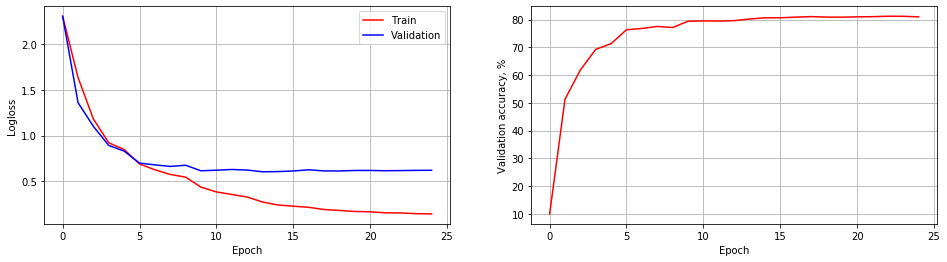

In [133]:
visualize_training(tr_loss[4], val_loss[4], val_acc[4])

#### Saving/loading

In [147]:
#torch.save(model_torch4.state_dict(), os.path.join('.', 'model_torch4_weights'))
model_torch4.load_state_dict(torch.load(os.path.join('.', 'model_torch4_weights')))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

#### Analyzing performance

In [156]:
predX, gt, _ = predict_torch(model_torch4, test_loader, GPU)
predX = predX.numpy()
gt = gt.numpy()
print('Test set accuracy: {0:.1f}%'.format(100*accuracy(gt, predX.argmax(axis=1))))
visualize_prediction_confidence(predX, gt)

RuntimeError: CUDA error: unspecified launch failure

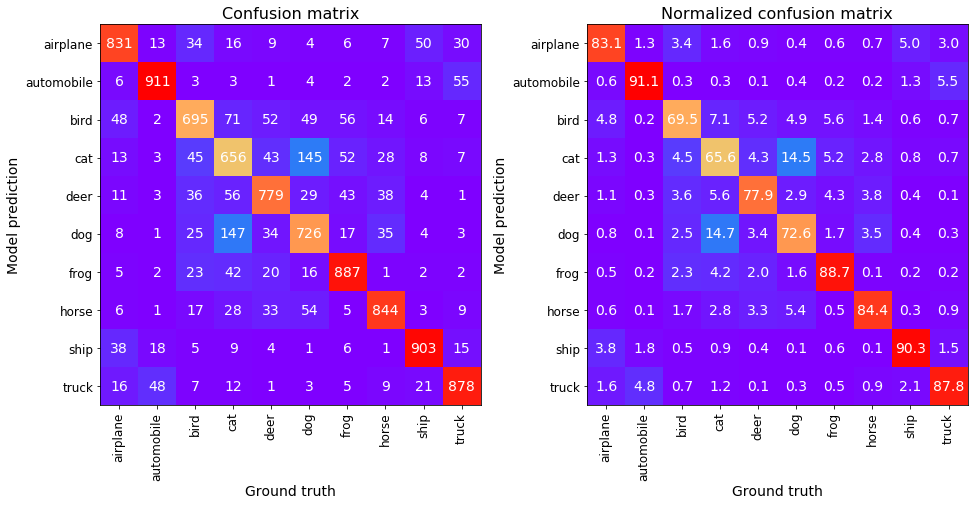

In [155]:
cm = confusion_matrix(gt, predX.argmax(axis=1))
visualize_confusion_matrix(cm, categories)

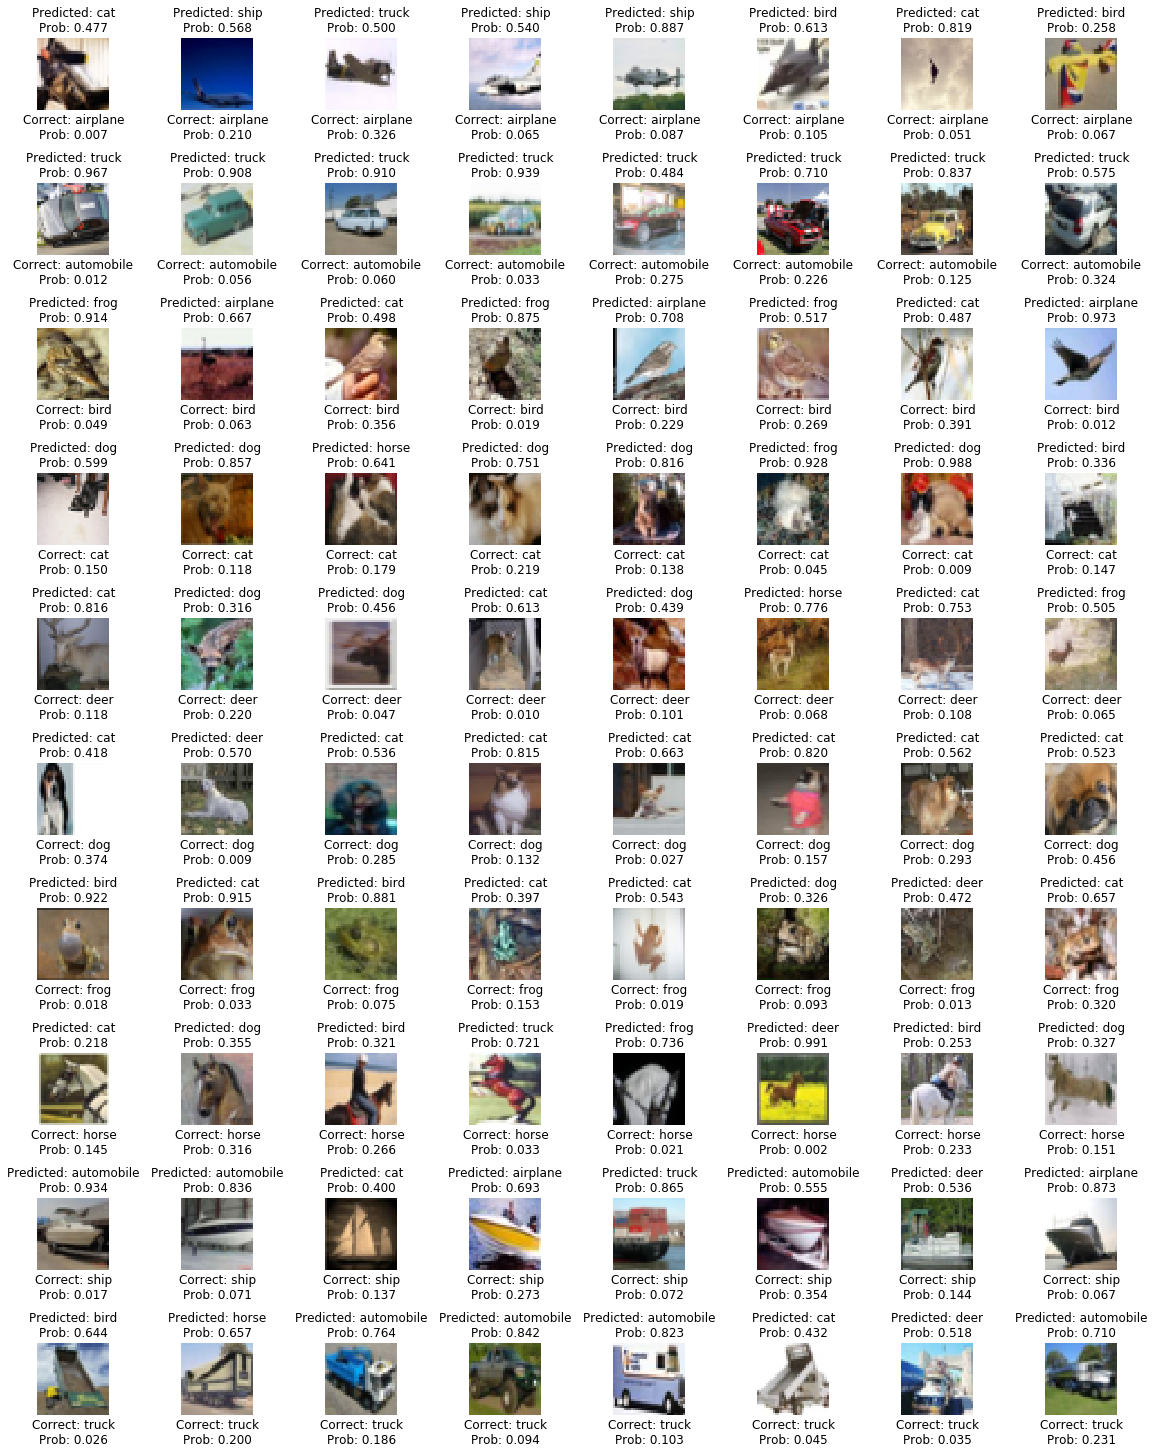

In [150]:
visualize_errors(predX, gt, X_test0, categories, 8)